In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import numpy as np

In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=100, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
nesting_list = [8, 16, 32, 64, 128, 256, 512]
relative_importance = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=100, efficient=False)
model = model.to(device)

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for i, n in enumerate(nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    print(f"| {'Train':^6} {epoch:^3} | Loss: {train_loss/((batch_idx+1) * len(nesting_list)):^7.3f} | Acc: {avg_acc:^6.3f}% |")

In [7]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct_top1 = {n: 0 for n in nesting_list}
    correct_top5 = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs[i].topk(5, 1, True, True)
                correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
    avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
    
    print("\n┌──────────┬────────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
    print("├──────────┼────────────┼────────────┤")
    
    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        top5 = 100. * correct_top5[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
    
    print("├──────────┼────────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
    print("└──────────┴────────────┴────────────┘")
    
    return avg_top1 

In [8]:
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

| Train   0  | Loss:  3.990  | Acc: 7.930 % |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │      8.85% │     32.84% │
│    16    │     10.87% │     35.43% │
│    32    │     11.58% │     36.70% │
│    64    │     12.36% │     37.99% │
│   128    │     12.78% │     38.53% │
│   256    │     12.56% │     38.25% │
│   512    │     13.09% │     38.16% │
├──────────┼────────────┼────────────┤
│ Average  │     11.73% │     36.84% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train   1  | Loss:  3.412  | Acc: 16.793% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     14.49% │     40.17% │
│    16    │     17.70% │     45.68% │
│    32    │     18.73% │     46.59% │
│    64    │     19.25% │     47.79% │
│   128    │     19.26% │

| Train  13  | Loss:  1.997  | Acc: 46.119% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     31.33% │     61.67% │
│    16    │     38.09% │     67.73% │
│    32    │     39.20% │     69.20% │
│    64    │     39.60% │     70.07% │
│   128    │     39.84% │     70.50% │
│   256    │     40.14% │     71.06% │
│   512    │     39.92% │     71.34% │
├──────────┼────────────┼────────────┤
│ Average  │     38.30% │     68.80% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  14  | Loss:  1.972  | Acc: 46.621% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     37.09% │     66.33% │
│    16    │     41.48% │     70.90% │
│    32    │     43.20% │     73.23% │
│    64    │     44.30% │     74.59% │
│   128    │     44.73% │

| Train  26  | Loss:  1.732  | Acc: 53.100% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     41.81% │     71.64% │
│    16    │     47.76% │     76.78% │
│    32    │     49.04% │     78.35% │
│    64    │     49.53% │     79.48% │
│   128    │     49.67% │     79.98% │
│   256    │     49.76% │     80.25% │
│   512    │     49.31% │     79.98% │
├──────────┼────────────┼────────────┤
│ Average  │     48.13% │     78.07% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  27  | Loss:  1.725  | Acc: 53.217% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     43.10% │     72.17% │
│    16    │     48.21% │     76.67% │
│    32    │     49.83% │     78.69% │
│    64    │     50.30% │     79.48% │
│   128    │     50.50% │

| Train  39  | Loss:  1.616  | Acc: 55.927% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     40.84% │     68.87% │
│    16    │     46.20% │     73.82% │
│    32    │     47.43% │     76.52% │
│    64    │     47.88% │     77.46% │
│   128    │     48.42% │     77.58% │
│   256    │     48.52% │     78.19% │
│   512    │     48.53% │     78.36% │
├──────────┼────────────┼────────────┤
│ Average  │     46.83% │     75.83% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  40  | Loss:  1.601  | Acc: 56.593% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     44.44% │     71.56% │
│    16    │     48.53% │     75.94% │
│    32    │     49.85% │     77.11% │
│    64    │     50.48% │     77.47% │
│   128    │     50.54% │

| Train  52  | Loss:  1.515  | Acc: 58.667% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     47.03% │     74.08% │
│    16    │     51.68% │     78.16% │
│    32    │     52.63% │     79.50% │
│    64    │     52.99% │     79.89% │
│   128    │     53.50% │     80.50% │
│   256    │     53.30% │     80.38% │
│   512    │     53.05% │     80.28% │
├──────────┼────────────┼────────────┤
│ Average  │     52.03% │     78.97% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  53  | Loss:  1.499  | Acc: 59.044% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     44.02% │     70.29% │
│    16    │     48.03% │     75.09% │
│    32    │     49.83% │     77.47% │
│    64    │     50.67% │     78.48% │
│   128    │     50.81% │

| Train  65  | Loss:  1.424  | Acc: 60.898% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     44.38% │     71.07% │
│    16    │     48.93% │     75.50% │
│    32    │     49.52% │     77.06% │
│    64    │     49.77% │     77.92% │
│   128    │     49.67% │     78.37% │
│   256    │     49.47% │     78.48% │
│   512    │     49.37% │     78.49% │
├──────────┼────────────┼────────────┤
│ Average  │     48.73% │     76.70% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  66  | Loss:  1.407  | Acc: 61.255% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     49.64% │     75.53% │
│    16    │     53.97% │     79.27% │
│    32    │     54.72% │     81.00% │
│    64    │     54.95% │     81.53% │
│   128    │     55.41% │

| Train  78  | Loss:  1.303  | Acc: 63.937% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     48.42% │     74.75% │
│    16    │     52.79% │     78.71% │
│    32    │     53.43% │     80.01% │
│    64    │     53.60% │     80.86% │
│   128    │     53.63% │     81.21% │
│   256    │     53.99% │     81.56% │
│   512    │     53.84% │     81.54% │
├──────────┼────────────┼────────────┤
│ Average  │     52.81% │     79.81% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  79  | Loss:  1.293  | Acc: 64.157% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     48.88% │     75.17% │
│    16    │     52.34% │     78.86% │
│    32    │     53.16% │     80.59% │
│    64    │     53.78% │     81.71% │
│   128    │     54.14% │

| Train  91  | Loss:  1.177  | Acc: 67.145% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     51.45% │     76.62% │
│    16    │     54.62% │     80.18% │
│    32    │     55.48% │     81.79% │
│    64    │     56.03% │     82.52% │
│   128    │     56.23% │     82.87% │
│   256    │     56.11% │     83.25% │
│   512    │     55.89% │     83.47% │
├──────────┼────────────┼────────────┤
│ Average  │     55.12% │     81.53% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  92  | Loss:  1.172  | Acc: 67.177% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     54.49% │     79.18% │
│    16    │     57.97% │     82.58% │
│    32    │     58.66% │     83.87% │
│    64    │     58.98% │     84.53% │
│   128    │     58.99% │

| Train  104 | Loss:  1.041  | Acc: 70.643% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     54.51% │     78.42% │
│    16    │     58.25% │     81.23% │
│    32    │     58.43% │     82.43% │
│    64    │     59.02% │     83.13% │
│   128    │     59.07% │     83.88% │
│   256    │     59.12% │     84.12% │
│   512    │     59.25% │     84.09% │
├──────────┼────────────┼────────────┤
│ Average  │     58.24% │     82.47% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  105 | Loss:  1.048  | Acc: 70.436% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     55.60% │     79.17% │
│    16    │     58.99% │     82.98% │
│    32    │     59.67% │     84.43% │
│    64    │     60.12% │     84.93% │
│   128    │     60.23% │

| Train  117 | Loss:  0.886  | Acc: 74.525% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     57.14% │     79.04% │
│    16    │     59.69% │     82.79% │
│    32    │     60.23% │     84.35% │
│    64    │     60.25% │     84.81% │
│   128    │     60.21% │     85.16% │
│   256    │     60.41% │     85.44% │
│   512    │     60.55% │     85.35% │
├──────────┼────────────┼────────────┤
│ Average  │     59.78% │     83.85% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  118 | Loss:  0.864  | Acc: 75.358% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     58.54% │     80.42% │
│    16    │     61.40% │     84.13% │
│    32    │     61.75% │     85.42% │
│    64    │     62.20% │     85.82% │
│   128    │     62.11% │

| Train  130 | Loss:  0.686  | Acc: 79.911% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     58.39% │     80.97% │
│    16    │     61.18% │     84.05% │
│    32    │     61.90% │     85.68% │
│    64    │     62.14% │     86.07% │
│   128    │     62.05% │     86.44% │
│   256    │     62.03% │     86.52% │
│   512    │     62.17% │     86.62% │
├──────────┼────────────┼────────────┤
│ Average  │     61.41% │     85.19% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  131 | Loss:  0.657  | Acc: 80.887% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     59.08% │     80.73% │
│    16    │     61.66% │     83.70% │
│    32    │     62.64% │     85.47% │
│    64    │     63.07% │     86.16% │
│   128    │     62.89% │

| Train  143 | Loss:  0.448  | Acc: 86.759% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     60.96% │     80.99% │
│    16    │     63.27% │     84.64% │
│    32    │     63.72% │     86.22% │
│    64    │     64.17% │     86.71% │
│   128    │     64.29% │     86.88% │
│   256    │     64.39% │     87.05% │
│   512    │     64.42% │     87.01% │
├──────────┼────────────┼────────────┤
│ Average  │     63.60% │     85.64% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  144 | Loss:  0.428  | Acc: 87.168% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     61.09% │     81.37% │
│    16    │     63.53% │     84.89% │
│    32    │     64.40% │     86.43% │
│    64    │     64.53% │     86.96% │
│   128    │     64.50% │

| Train  156 | Loss:  0.211  | Acc: 93.663% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     60.66% │     80.91% │
│    16    │     63.46% │     84.33% │
│    32    │     63.95% │     85.98% │
│    64    │     64.04% │     86.44% │
│   128    │     64.06% │     86.70% │
│   256    │     64.03% │     86.89% │
│   512    │     64.09% │     87.01% │
├──────────┼────────────┼────────────┤
│ Average  │     63.47% │     85.47% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  157 | Loss:  0.207  | Acc: 93.822% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     62.55% │     82.03% │
│    16    │     64.96% │     84.90% │
│    32    │     65.32% │     86.53% │
│    64    │     65.58% │     86.92% │
│   128    │     65.66% │

| Train  169 | Loss:  0.049  | Acc: 98.702% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     65.79% │     83.13% │
│    16    │     67.87% │     85.77% │
│    32    │     68.49% │     87.28% │
│    64    │     68.57% │     87.86% │
│   128    │     68.67% │     88.04% │
│   256    │     68.73% │     88.09% │
│   512    │     68.76% │     88.16% │
├──────────┼────────────┼────────────┤
│ Average  │     68.13% │     86.90% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  170 | Loss:  0.042  | Acc: 98.986% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     65.95% │     82.83% │
│    16    │     67.91% │     85.77% │
│    32    │     68.48% │     87.47% │
│    64    │     68.77% │     87.96% │
│   128    │     68.83% │

| Train  182 | Loss:  0.014  | Acc: 99.753% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.29% │     83.74% │
│    16    │     69.22% │     86.66% │
│    32    │     70.00% │     88.05% │
│    64    │     70.14% │     88.65% │
│   128    │     70.22% │     88.69% │
│   256    │     70.17% │     88.81% │
│   512    │     70.20% │     88.88% │
├──────────┼────────────┼────────────┤
│ Average  │     69.61% │     87.64% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  183 | Loss:  0.014  | Acc: 99.752% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.32% │     83.77% │
│    16    │     69.30% │     86.34% │
│    32    │     70.11% │     88.03% │
│    64    │     70.24% │     88.45% │
│   128    │     70.19% │

| Train  195 | Loss:  0.010  | Acc: 99.873% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.35% │     83.91% │
│    16    │     69.55% │     86.46% │
│    32    │     69.95% │     88.03% │
│    64    │     70.15% │     88.36% │
│   128    │     70.18% │     88.52% │
│   256    │     70.21% │     88.62% │
│   512    │     70.23% │     88.65% │
├──────────┼────────────┼────────────┤
│ Average  │     69.66% │     87.51% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  196 | Loss:  0.010  | Acc: 99.868% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.32% │     83.79% │
│    16    │     69.46% │     86.62% │
│    32    │     70.03% │     88.04% │
│    64    │     70.08% │     88.77% │
│   128    │     70.14% │

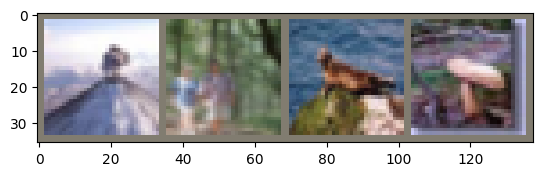

GroundTruth:	 49	33	72	51
Size		Image 1	Image 2	Image 3	Image 4
8		56	33	55	91
16		68	33	55	91
32		68	33	55	91
64		68	33	55	91
128		68	33	55	91
256		68	33	55	91
512		68	33	55	91


In [9]:
import time
from datetime import timedelta

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(200):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrl.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1) + \
          torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))